# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [19]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [20]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [23]:
  
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())
        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['exclam_count'] = movie_data['review'].str.count("\!")
    movie_data['q_count'] = movie_data['review'].str.count("\?")
    movie_data['q_star'] = movie_data['review'].str.count("\*")
    movie_data['q_hash'] = movie_data['review'].str.count("\#")
    
    # uppercase letter count
    import string
    movie_data['upper'] = [sum(1 for letter in c if letter.isupper()) for c in movie_data['review']]    

    X_quant_features = movie_data[["word_count", "punc_count",'exclam_count','q_count','upper','q_star','q_hash']]
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [24]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=28)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash
0         433          20             1        2     59       0       0
1         15

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [26]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9985, 'Neg': 10015, 'TP': 5297, 'TN': 4611, 'FP': 5404, 'FN': 4688, 'Accuracy': 0.4954, 'Precision': 0.4950004672460518, 'Recall': 0.5304957436154232, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [27]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9985, 'Neg': 10015, 'TP': 9985, 'TN': 10015, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [28]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9985, 'Neg': 10015, 'TP': 9985, 'TN': 10015, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9985, 'Neg': 10015, 'TP': 9569, 'TN': 9861, 'FP': 154, 'FN': 416, 'Accuracy': 0.9715, 'Precision': 0.9841612670986322, 'Recall': 0.9583375062593891, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [30]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9985, 'Neg': 10015, 'TP': 9985, 'TN': 10015, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [31]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9985, 'Neg': 10015, 'TP': 9955, 'TN': 10009, 'FP': 6, 'FN': 30, 'Accuracy': 0.9982, 'Precision': 0.9993976508382693, 'Recall': 0.9969954932398598, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

C:\Users\Michael Desai\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9985, 'Neg': 10015, 'TP': 7288, 'TN': 4828, 'FP': 5187, 'FN': 2697, 'Accuracy': 0.6058, 'Precision': 0.5842084168336673, 'Recall': 0.7298948422633951, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

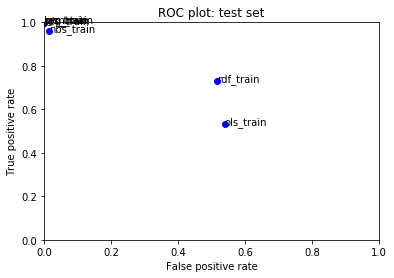

In [33]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [34]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [35]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
8
I am oh soooo glad I have not spent money to go to the cinema on it :-). It is nothing more than compilation of elements of few other classic titles like The Thing, Final Fantasy, The Abyss etc. framed in rather dull and meaningless scenario. I really can not figure out what was the purpose of creating this movie - it has absolutely nothing new to offer in its storyline which additionally is also senseless. Moreover there is nothing to watch - the FX'es look like there were taken from a second hand store, you generally saw all of them in other movies. But it is definitely a good lullaby.
* * * * * * * * * 
90
Sitting down to watch the 14th season of the Bachelor (\On the Wings of Love\"), I knew I would be in for an \"interesting\" time. I had watched some of the previous seasons of the Bachelor in passing; watching an episode or two and missing the next three or so. I find that the Bachelor is often appealing and intriguing, though its quality and morali

2146
First of all, I firmly believe that Norwegian movies are continually getting better. From the tedious emotional films of the 70's and 80's, movies from this place actually started to contain a bit of humour. Imagine.. Actual comedies were made! Movies were actually starting to get entertaining and funny, as opposed to long, dark, depressing and boring.<br /><br />During the 90's and 00's several really great movies were made by a 'new generation' of filmmakers. Movie after movie were praised by critics and played loads of money. It became the norm!<br /><br />Then came United...<br /><br />*MINOR SPOILERS* It's just simply not funny. Not once. Not ever. But the thing is... We THINK its funny. Because we're used to norwegian movies to be funny. Especially with a cast like this with a few really funny comedians. But.. They neither say nor do anything funny! Where's the humor? Show me the humor! Is it the awkward clerk played by Harald Eia? Is it the overacting totally ridiculously u

4386
I honestly had somewhat high expectations when I first began to watch this movie, but it turned out to be probably one of the most boring films I have ever seen!<br /><br />First of all, the pace is incredibly slow, so it seems much longer than it is (and it's not short).I'm sure when Jane Austen wrote the book, she made it several pages long, filled it with description, and didn't intend for people to read in in one day, or it might drag and lose it's appeal, which \Emma\" most certainly did. Now \"Sense and Sensibility\" had this flaw of a slow pace, but at least it had lively lines to make up for it, as well as some good performances!<br /><br />That brings me to flaw #2, which is of course, the acting. While I don't happen to care for basically anybody involved in this film, I am sure they are capable of good work, but I didn't see much of it in this movie. It was like people were trying too hard to be witty, too hard to be \"upper-class\", too hard to be British (well, some o

6774
If you are looking for eye candy, you may enjoy Sky Captain. Sky Captain is just a video game injected with live performers. The visials are nice and interesting to look at during the entire movie. Now, saying that, the visuals are the ONLY thing good in Sky Captain.<br /><br />After ten minutes, I knew I was watching one of the worse movies of all time. I was hoping this movie would get better, but it never achieved any degree of interest. After thirty minutes, the urge to walk out kept growing and growing. Now, I own over 2000 movies and have seen probably five times that number. Yet, this is only the second movie I felt like walking out of my entire life.<br /><br />Acting---there is none. The three main performers are pitiful. Jude Law (also in the other movie I wanted to walk out on) is just awful in the title role. I would rather sit through Ben Affleck in Gigli than watch Law again.<br /><br />Paltrow tries SO hard to be campy, that it backfires in her face. The last articl

8780
I can hardly believe that this inert, turgid and badly staged film is by a filmmaker whose other works I've quite enjoyed. The experience of enduring THE LADY AND THE DUKE (and no other word but \enduring\" will do), left me in a vile mood, a condition relieved only by reading the IMDb user comment by ali-112. For not only has Rohmer attempted (with success) to make us see the world through the genre art of 18th century France but, as ali has pointed out, has shown (at the cost of alienating his audience) the effects of both class consciousness and the revolution it inspired through the eyes of a dislikably elitist woman of her times. The director has accomplished something undeniably difficult, but I question whether it was worth the effort it took for him to do so -- or for us to watch the dull results of his labor."
* * * * * * * * * 
9086
The Radar Men from the Moon is a pretty typical fare of 1950's serials. The special effects are pretty cheap, the lunar rovers are obviously

10844
Dull haunted house thriller finds an American family moving into a 200 year old house in Japan where a violent murder suicide love triangle occurred. <br /><br />Novel setting is about the only element of interest in this very slow moving horror flick by the director of Motel Hell. The film generates zero suspense and is composed of somewhat choppy scenes that rarely seem to be leading anywhere overall. <br /><br />One obvious example is a fairly early scene where the male lead visits a temple after realizing that his house is haunted as the monk had earlier warned. The monk recounts the history of the house (which the viewer is already familiar with from the opening sequence) and then the film simply cuts away to something else. Earlier the monk had offered to help. Well, where is the help? The family continues to stay in the haunted house as things get worse and worse and no mention of the monk is made until nearly the very end when he turns up again to do what he should have d

13022
Originally aired as an ABC Movie of the Week. This involves two young innocent female college students who are railroaded into a prison camp in a little Southern town. They aren't allowed phone calls and nobody knows they're there. What follows is rape, torture, beatings, humiliation and degradation leading to a very disturbing conclusion.<br /><br />The TV version was (for its time) grim. No nudity and the beatings were pretty tame but the overall feeling of sleaziness wore one down. The unrated version is even worse--there's plentiful nudity, the violence is extreme and, in one particularly disgusting sequence, we see a crying female prisoner forced to strip while a lesbian guard \uses\" her. YUCK! There's nothing wrong with exploitation films but this one just goes over the brink. You get the feeling that the filmmakers enjoy having these poor women being tortured and degraded--all this is shoved in your face like you're supposed to enjoy it. The needlessly downbeat ending doe

15242
WARNING! This review will reveal the ending of the movie, \Scoop.\" If you don't want to know how the movie ends, don't read this review!<br /><br />\"Scoop\" is so bad you'll think \"Annie Hall\" was a fluke.<br /><br />It gets one star because you get to see Hugh Jackman's naked chest. That's the only thing \"Scoop\" has going for it.<br /><br />Woody Allen's misogyny, and his fixation on women young enough, at this point, to be his granddaughter, has crippled any ability to make movies he may have had at any point.<br /><br />The plot seems promising: a ghost, Ian McShane, directs a fluffy headed student, Scarlett Johansson, to investigate whether or not an English Lord, Hugh Jackman, is the notorious Tarot Card Killer of prostitutes. A magician, Woody Allen, helps the girl.<br /><br />Promising plot notwithstanding, the movie completely lacks charm, or humor, or atmosphere. It's an amazingly leaden, amateurish effort for someone who has made even one previous film, never mind

17729
I can fondly remember Bo Derek's heyday and the UK press attention (the mucky Sun & News of the World papers especially)- all following her small role in \10\" with Dudley Moore. Understandably, much fuss was made of her photogenic face, crystal clear blue eyes and her perfectly formed bouncing breasts. <br /><br />Unfortunately, acting is, and never was, her forte! I think they should make one of the triple disc collections you always find in the bargain DVD bins- Orca, Tarzan the Ape-man and Bolero. All these films could be nominated for the \"So Bad They Are Great\".<br /><br />It would be a guilty \"must buy\" of mine! Should you ever read your press, or this comment Ms Derek, please do not be offended- ALways had a soft spot for you and there are more important things going on in the world to worry about than your acting ability. Much Love.x"
* * * * * * * * * 
17771
I saw this in the market place at the Cannes Film Festival. <br /><br />It's a real cheapo prod - nothing wro

19954
***THIS POST CONTAINS SPOILER(S)*** <br /><br />I'm not a big fan of Chuck Norris as an actor, but I worship him in all other ways. He also have his own fan web site with \Chuck Norris facts\" that is really entertaining. But this movie looks like someone was joking with the audience putting all those \"facts\" into one movie. I really don't remember when I wasted my time more than with this \"action\". I don't know what's the worst this movie can offer you: unoriginal and thousand-times-made plot of terrorists who are trying to nuke US by smuggling nuke on US soil or perhaps that \"great\" dialogs and Chucks words of wisdom about life and everything else. Someone may find the worst that terrorists actually speak English in everyday life. It's a never ending list of crap. Not to mention huge amount of archive footage used in film, that is kinda annoying. The chief terrorist send his comrades message through the media when he is captured and the only guy smart enough to see the tr

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [36]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 1378, 'TN': 1039, 'FP': 1446, 'FN': 1137, 'Accuracy': 0.4834, 'Precision': 0.48796033994334276, 'Recall': 0.5479125248508946, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [37]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 2100, 'TN': 2053, 'FP': 432, 'FN': 415, 'Accuracy': 0.8306, 'Precision': 0.8293838862559242, 'Recall': 0.8349900596421471, 'desc': 'svm_test'}


### MODEL: logistic regression

In [38]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 2107, 'TN': 2055, 'FP': 430, 'FN': 408, 'Accuracy': 0.8324, 'Precision': 0.8305084745762712, 'Recall': 0.8377733598409542, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [39]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 1856, 'TN': 1835, 'FP': 650, 'FN': 659, 'Accuracy': 0.7382, 'Precision': 0.7406225059856345, 'Recall': 0.7379721669980119, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [40]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 2116, 'TN': 2051, 'FP': 434, 'FN': 399, 'Accuracy': 0.8334, 'Precision': 0.8298039215686275, 'Recall': 0.841351888667992, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [41]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 2178, 'TN': 2204, 'FP': 281, 'FN': 337, 'Accuracy': 0.8764, 'Precision': 0.8857259048393656, 'Recall': 0.8660039761431412, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [42]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2515, 'Neg': 2485, 'TP': 1866, 'TN': 1183, 'FP': 1302, 'FN': 649, 'Accuracy': 0.6098, 'Precision': 0.5890151515151515, 'Recall': 0.741948310139165, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

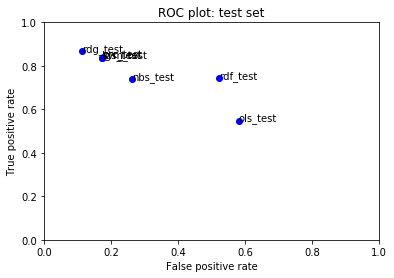

In [43]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [44]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=28, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash
0         131           5             0        0      7       0       0
1         169          15             1        0     15       0       0
2         176          18             0        0     25       0       0
3 

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [45]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.46724


In [46]:
raw_data.head()

,id,review,word_count,punc_count,exclam_count,q_count,q_star,q_hash,upper
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,0,0,0,7
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1,0,0,0,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0,0,0,0,25
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0,0,0,0,10
4,12128_7,A very accurate depiction of small time mob li...,133,8,0,0,0,0,17


In [47]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [48]:
my_submission.shape

(25000, 2)

In [50]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('misha_moviereview_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation